# Predecir resultado (Ganar / Perder) en partidos de Beisbol a lo largo de temporadas o una temporada


## Proceso de decisión para llegar a un modelo 

##### Teoría del Aprendizaje Estadístico

Al aplicar la Teoría del Aprendizaje Estadístico a este problema de predecir resultados de partidos de béisbol, podemos construir un modelo que aprenda patrones a partir de datos históricos y haga predicciones útiles para futuros encuentros.


##### Datos a utilizar
- Visitante o local 
- Oponente 
- Carreras a favor
- Carreras en contra 
- Datos temporales
- Pitcher abridor de nuestro equipo

## Análisis Exploratorio de Datos (EDA)


In [2]:
#importe de librerias 
from pybaseball import schedule_and_record
from pybaseball import team_game_logs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
import re
from sklearn.metrics import precision_score, mean_absolute_error
from datetime import datetime





In [3]:
#establecemos nuestros dataframes iniciales

games = schedule_and_record(2023, 'NYY')
gamelogs = team_game_logs('2023', 'NYY', log_type="pitching")





http://www.baseball-reference.com/teams/NYY/2023-schedule-scores.shtml


In [4]:
gamelogs.index += 1



In [5]:

starter=gamelogs['PitchersUsed'].str.split(',', expand=True)[0].str.split('(', expand=True)[0].str.split('.', expand=True)[1].str.strip()
games['Starter']= starter



In [6]:
games['Date'] = games['Date'].astype(str) + ', 2023'
games.columns

Index(['Date', 'Tm', 'Home_Away', 'Opp', 'W/L', 'R', 'RA', 'Inn', 'W-L',
       'Rank', 'GB', 'Win', 'Loss', 'Save', 'Time', 'D/N', 'Attendance', 'cLI',
       'Streak', 'Orig. Scheduled', 'Starter'],
      dtype='object')

In [7]:
def remove_parentheses(date_str):
    return re.sub(r'\s*\(.*?\)\s*', '', date_str)

games['Date'] = games['Date'].apply(remove_parentheses)


In [8]:
games['Date'] = pd.to_datetime(games['Date'], format='%A, %b %d, %Y')


In [9]:
games['Date'].unique()

array(['2023-03-30T00:00:00.000000000', '2023-04-01T00:00:00.000000000',
       '2023-04-02T00:00:00.000000000', '2023-04-03T00:00:00.000000000',
       '2023-04-04T00:00:00.000000000', '2023-04-05T00:00:00.000000000',
       '2023-04-07T00:00:00.000000000', '2023-04-08T00:00:00.000000000',
       '2023-04-09T00:00:00.000000000', '2023-04-10T00:00:00.000000000',
       '2023-04-11T00:00:00.000000000', '2023-04-12T00:00:00.000000000',
       '2023-04-13T00:00:00.000000000', '2023-04-14T00:00:00.000000000',
       '2023-04-15T00:00:00.000000000', '2023-04-16T00:00:00.000000000',
       '2023-04-18T00:00:00.000000000', '2023-04-19T00:00:00.000000000',
       '2023-04-20T00:00:00.000000000', '2023-04-21T00:00:00.000000000',
       '2023-04-22T00:00:00.000000000', '2023-04-23T00:00:00.000000000',
       '2023-04-24T00:00:00.000000000', '2023-04-25T00:00:00.000000000',
       '2023-04-26T00:00:00.000000000', '2023-04-27T00:00:00.000000000',
       '2023-04-28T00:00:00.000000000', '2023-04-29

In [10]:
games.isnull().sum()

Date                 0
Tm                   0
Home_Away            0
Opp                  0
W/L                  0
R                    0
RA                   0
Inn                  0
W-L                  0
Rank                 0
GB                   0
Win                  0
Loss                 0
Save                 0
Time                 0
D/N                  0
Attendance           1
cLI                  0
Streak               0
Orig. Scheduled    155
Starter              0
dtype: int64

In [11]:
# añadamos dos columnas para facilitar el analisis wins and losses
games[['Wins', 'Losses']] = games['W-L'].str.split('-', expand=True)

games['Wins'] = games['Wins'].astype(int)
games['Losses'] = games['Losses'].astype(int)

In [12]:
#calculando Run differential
games['Run_Differential']=games['R'] - games['RA']


In [13]:
games.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 1 to 162
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              162 non-null    datetime64[ns]
 1   Tm                162 non-null    object        
 2   Home_Away         162 non-null    object        
 3   Opp               162 non-null    object        
 4   W/L               162 non-null    object        
 5   R                 162 non-null    float64       
 6   RA                162 non-null    float64       
 7   Inn               162 non-null    float64       
 8   W-L               162 non-null    object        
 9   Rank              162 non-null    float64       
 10  GB                162 non-null    object        
 11  Win               162 non-null    object        
 12  Loss              162 non-null    object        
 13  Save              162 non-null    object        
 14  Time              162 non-

In [14]:
games.drop(columns=['Attendance', 'Orig. Scheduled'], inplace=True)
games.columns



Index(['Date', 'Tm', 'Home_Away', 'Opp', 'W/L', 'R', 'RA', 'Inn', 'W-L',
       'Rank', 'GB', 'Win', 'Loss', 'Save', 'Time', 'D/N', 'cLI', 'Streak',
       'Starter', 'Wins', 'Losses', 'Run_Differential'],
      dtype='object')

In [15]:
games['Opp'].value_counts()



BAL    13
BOS    13
TOR    13
TBR    13
HOU     7
MIN     7
DET     7
TEX     7
KCR     6
SEA     6
CHW     6
OAK     6
LAA     6
CLE     6
NYM     4
MIL     3
WSN     3
ATL     3
MIA     3
PIT     3
SFG     3
COL     3
CHC     3
STL     3
PHI     3
LAD     3
SDP     3
CIN     3
ARI     3
Name: Opp, dtype: int64

In [16]:
games['Win'].value_counts().describe()


count    93.000000
mean      1.741935
std       2.010317
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      15.000000
Name: Win, dtype: float64

In [17]:
games['Loss'].value_counts().describe()


count    92.000000
mean      1.760870
std       1.817918
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       9.000000
Name: Loss, dtype: float64

In [18]:
games['D/N'].value_counts()

N    106
D     56
Name: D/N, dtype: int64

In [19]:
games['Starter'].value_counts()

Cole        33
Schmidt     32
Germán      19
Severino    18
Rodón       14
Brito       13
Cortés      12
King         9
Vásquez      5
Hamilton     3
Weaver       3
Cordero      1
Name: Starter, dtype: int64

In [20]:
games['W/L'].unique()



array(['W', 'L', 'W-wo', 'L-wo'], dtype=object)

In [21]:
games['W/L'] = games['W/L'].replace({'W-wo': 'W', 'L-wo': 'L'})


In [22]:
games['GB'].unique()

array(['Tied', '1.0', '2.0', '3.0', '4.0', '5.0', '4.5', '6.0', '7.0',
       '8.0', '8.5', '10.0', '9.0', '7.5', '6.5', '5.5', '9.5', '10.5',
       '11.0', '12.0', '12.5', '11.5', '13.0', '14.0', '15.0', '16.0',
       '17.0', '18.0', '19.0', '18.5', '17.5', '19.5', '20.5', '16.5'],
      dtype=object)

In [23]:
def clean_convert(element):
    if 'up' in element:
        element = element.replace('up', '').strip()
    if element == 'Tied':
        element = '0'
    return float(element)
games['GB'] = games['GB'].apply(clean_convert)


In [24]:
games['GB'].isnull().sum()

0

In [25]:
games['R'].describe()

count    162.000000
mean       4.154321
std        2.767538
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       12.000000
Name: R, dtype: float64

In [26]:
games['RA'].describe()

count    162.000000
mean       4.308642
std        3.050881
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       15.000000
Name: RA, dtype: float64

In [27]:
games['Run_Differential'].describe()

count    162.000000
mean      -0.154321
std        4.321794
min      -13.000000
25%       -3.000000
50%        1.000000
75%        3.000000
max       11.000000
Name: Run_Differential, dtype: float64

In [28]:
games.dtypes

Date                datetime64[ns]
Tm                          object
Home_Away                   object
Opp                         object
W/L                         object
R                          float64
RA                         float64
Inn                        float64
W-L                         object
Rank                       float64
GB                         float64
Win                         object
Loss                        object
Save                        object
Time                        object
D/N                         object
cLI                         object
Streak                       int64
Starter                     object
Wins                         int64
Losses                       int64
Run_Differential           float64
dtype: object

In [29]:
games.drop(columns=['W-L'], inplace=True)

In [30]:
#Agregar columna Winning percentage
games['Winning-Percentage']=games['Wins']/(games['Wins'] + games['Losses'] )


# Visualizaciones


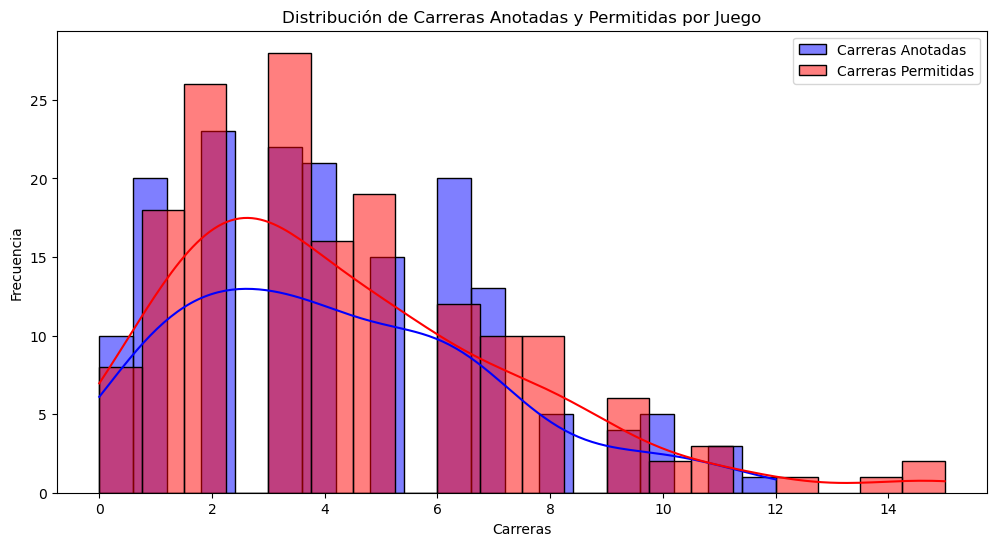

In [31]:
plt.figure(figsize=(12, 6))

sns.histplot(games['R'], bins=20, kde=True, color='blue', alpha=0.5, label='Carreras Anotadas')

sns.histplot(games['RA'], bins=20, kde=True, color='red', alpha=0.5, label='Carreras Permitidas')

plt.title('Distribución de Carreras Anotadas y Permitidas por Juego')
plt.xlabel('Carreras')
plt.ylabel('Frecuencia')

plt.legend()

plt.show()

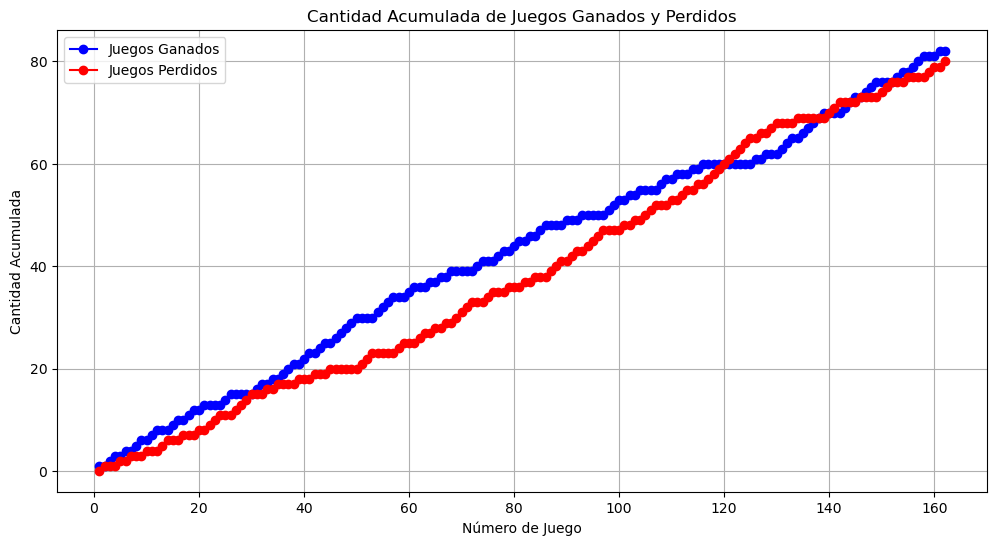

In [32]:
plt.figure(figsize=(12, 6))

plt.plot(games.index, games['Wins'], marker='o', linestyle='-', color='blue', label='Juegos Ganados')

plt.plot(games.index, games['Losses'], marker='o', linestyle='-', color='red', label='Juegos Perdidos')

plt.title('Cantidad Acumulada de Juegos Ganados y Perdidos')
plt.xlabel('Número de Juego')
plt.ylabel('Cantidad Acumulada')
plt.grid(True)

plt.legend()

plt.show()

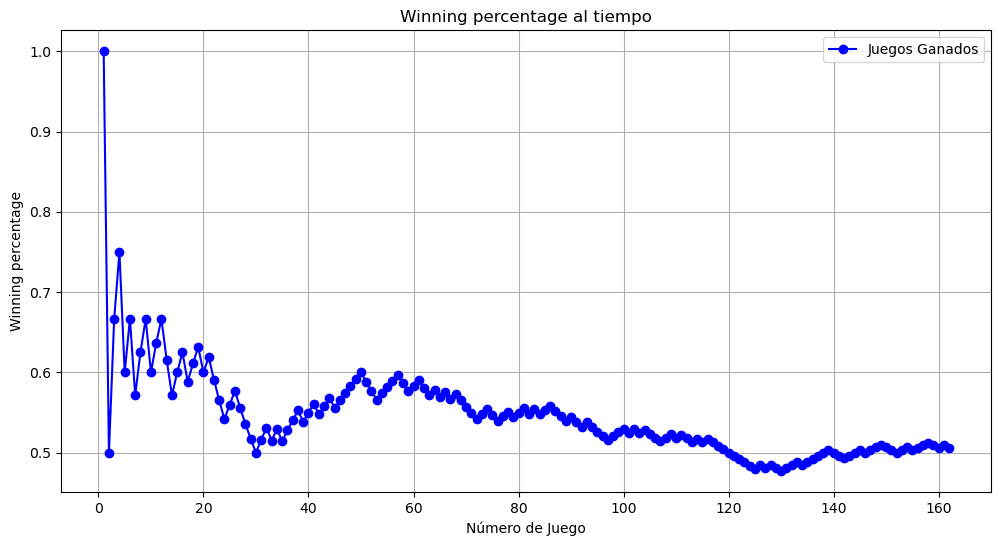

In [33]:
plt.figure(figsize=(12, 6))

plt.plot(games.index, games['Winning-Percentage'], marker='o', linestyle='-', color='blue', label='Juegos Ganados')


plt.title('Winning percentage al tiempo')
plt.xlabel('Número de Juego')
plt.ylabel('Winning percentage')
plt.grid(True)

plt.legend()

plt.show()

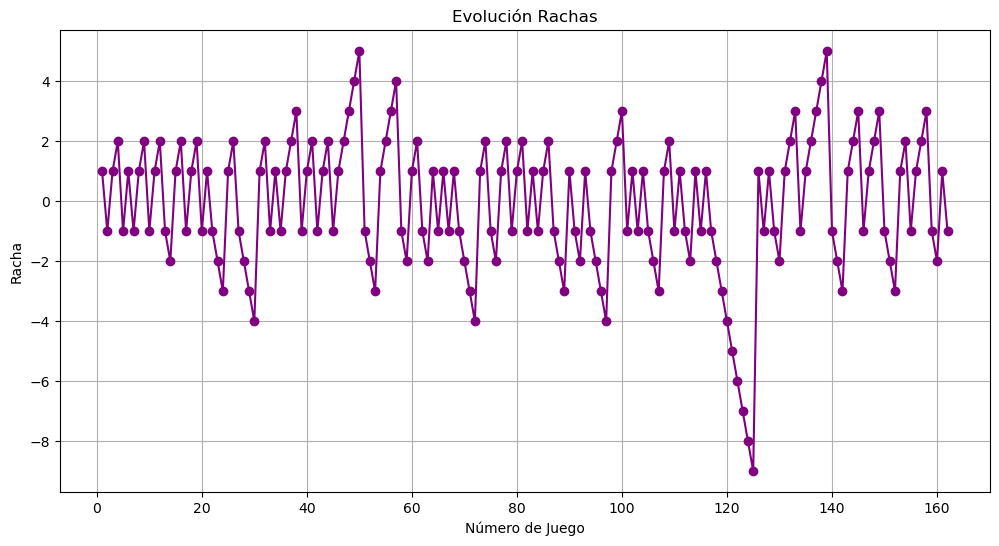

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(games.index, games['Streak'], marker='o', linestyle='-', color='purple')
plt.title('Evolución Rachas')
plt.xlabel('Número de Juego')
plt.ylabel('Racha')
plt.grid(True)
plt.show()

In [35]:
games['Home_Away_code'] = games['Home_Away'].astype('category').cat.codes
games['Opp_code'] = games['Opp'].astype('category').cat.codes
games['Win_code'] = games['Win'].astype('category').cat.codes
games['Loss_code'] = games['Loss'].astype('category').cat.codes
games['D/N_code'] = games['D/N'].astype('category').cat.codes
games['Starter_code'] = games['Starter'].astype('category').cat.codes
games['hour'] = games['Time'].str.replace(':.+', '', regex =True).astype('int')
games['day'] = games['Date'].dt.dayofweek
games['month'] = games['Date'].dt.month
games['W/L_code'] = games['W/L'].astype('category').cat.codes

In [36]:
games.dtypes

Date                  datetime64[ns]
Tm                            object
Home_Away                     object
Opp                           object
W/L                           object
R                            float64
RA                           float64
Inn                          float64
Rank                         float64
GB                           float64
Win                           object
Loss                          object
Save                          object
Time                          object
D/N                           object
cLI                           object
Streak                         int64
Starter                       object
Wins                           int64
Losses                         int64
Run_Differential             float64
Winning-Percentage           float64
Home_Away_code                  int8
Opp_code                        int8
Win_code                        int8
Loss_code                       int8
D/N_code                        int8
S

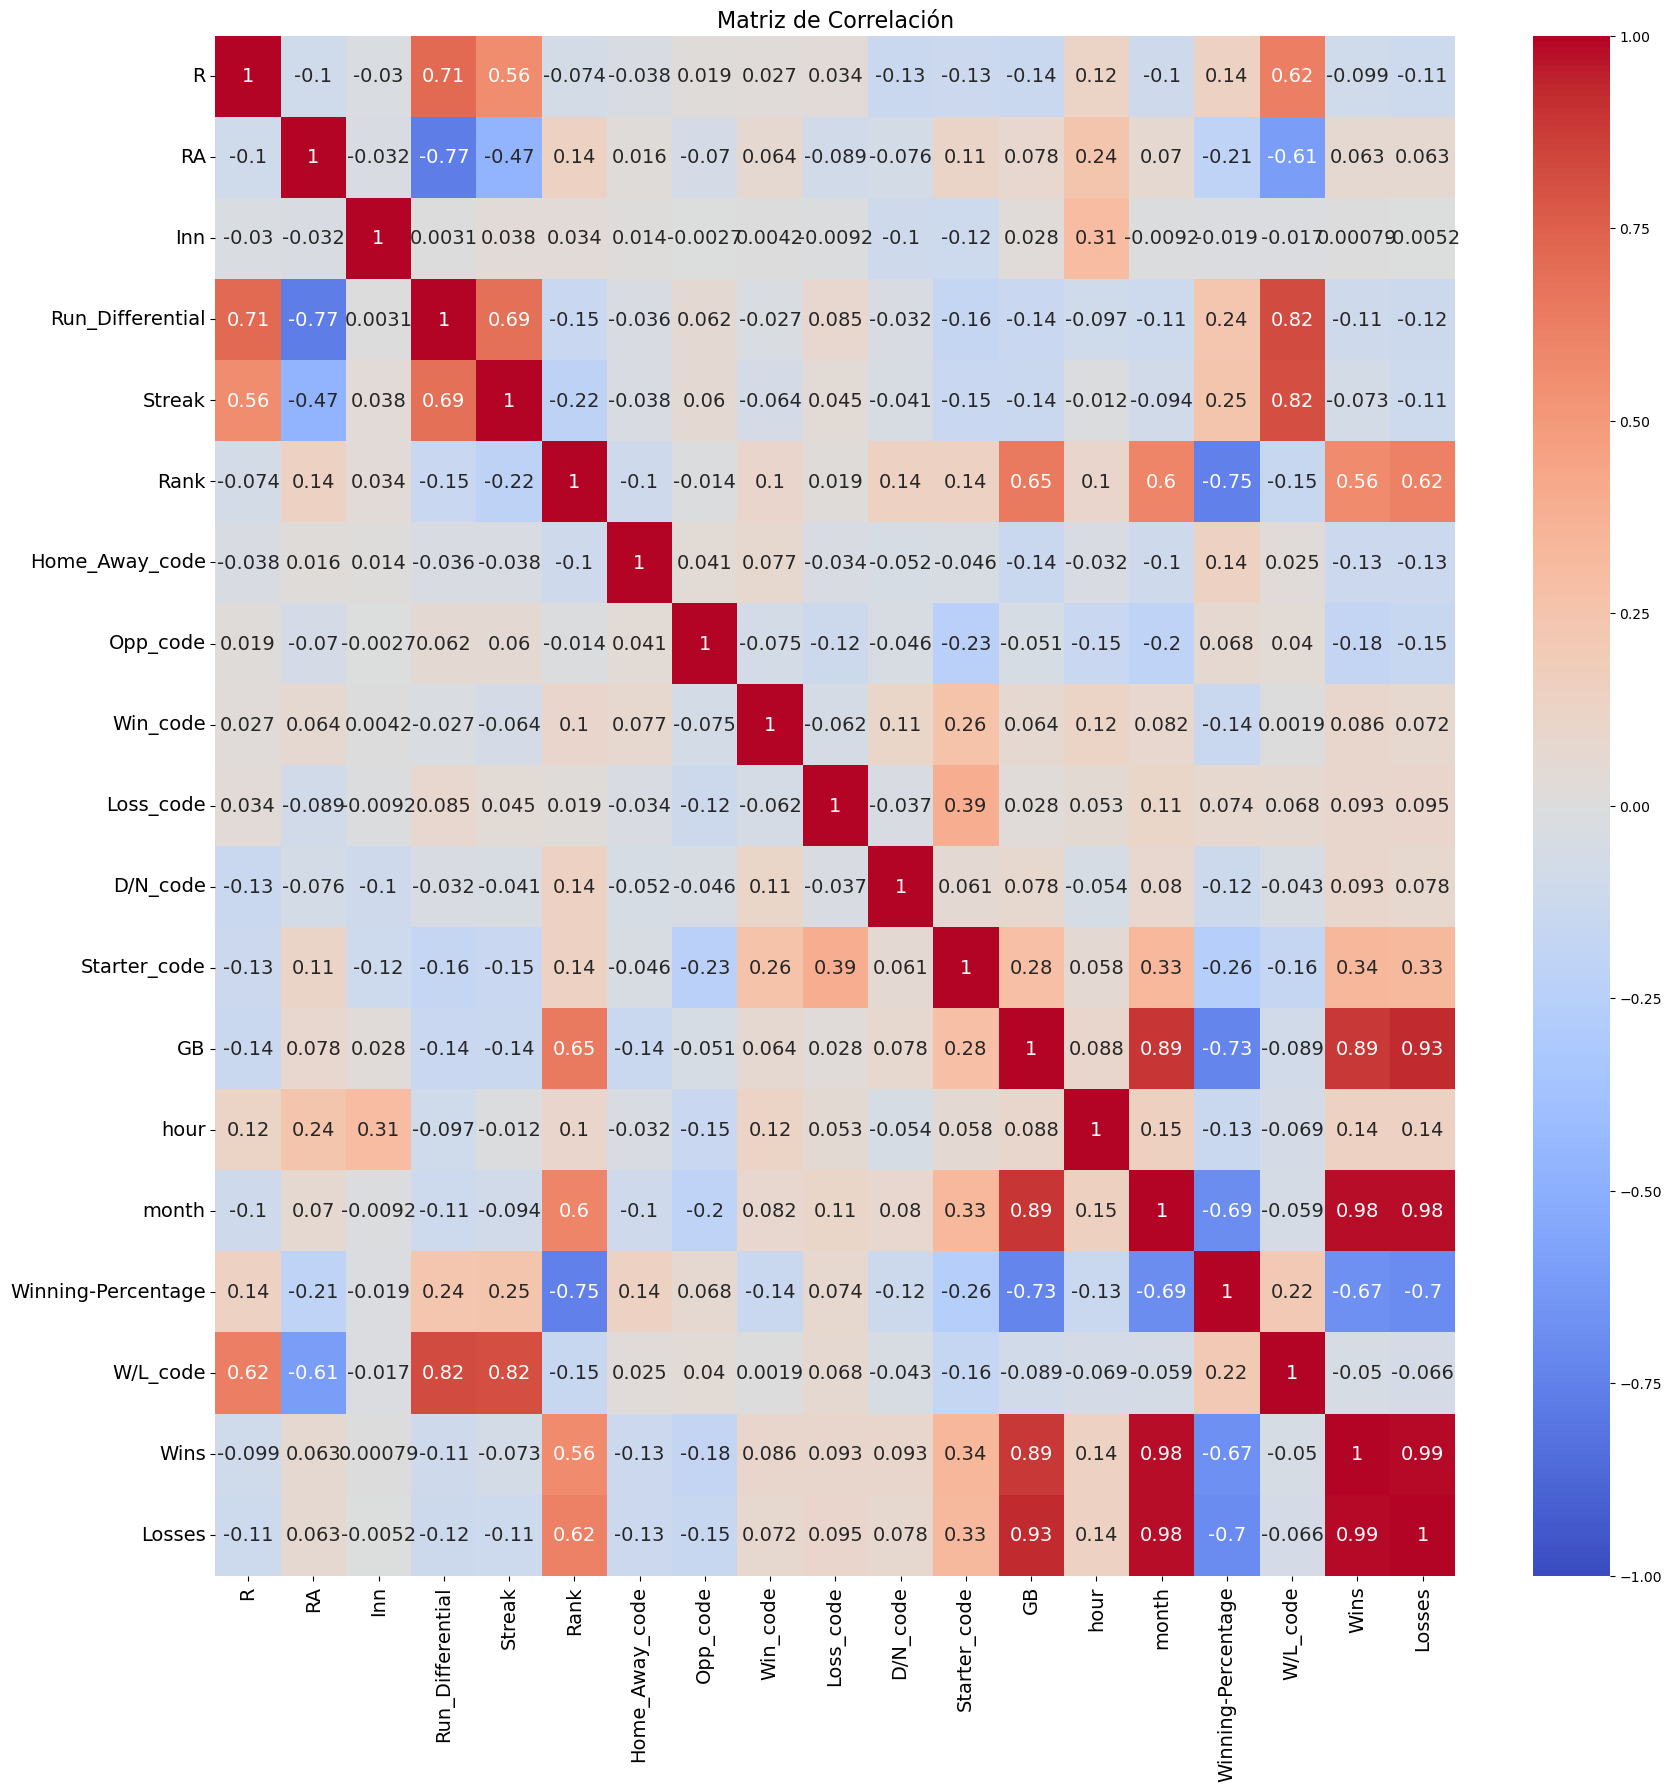

In [37]:
corr_matrix = games[['R', 'RA', 'Inn', 'Run_Differential', 'Streak', 'Rank', 'Home_Away_code', 
                     'Opp_code', 'Win_code', 'Loss_code', 'D/N_code', 'Starter_code', 
                     'GB', 'hour', 'month', 'Winning-Percentage', 'W/L_code', 'Wins','Losses']].corr()

plt.figure(figsize=(20,20))  

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 14})  # Tamaño de las anotaciones

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.title('Matriz de Correlación', fontsize=16)  # Tamaño del título

plt.show()

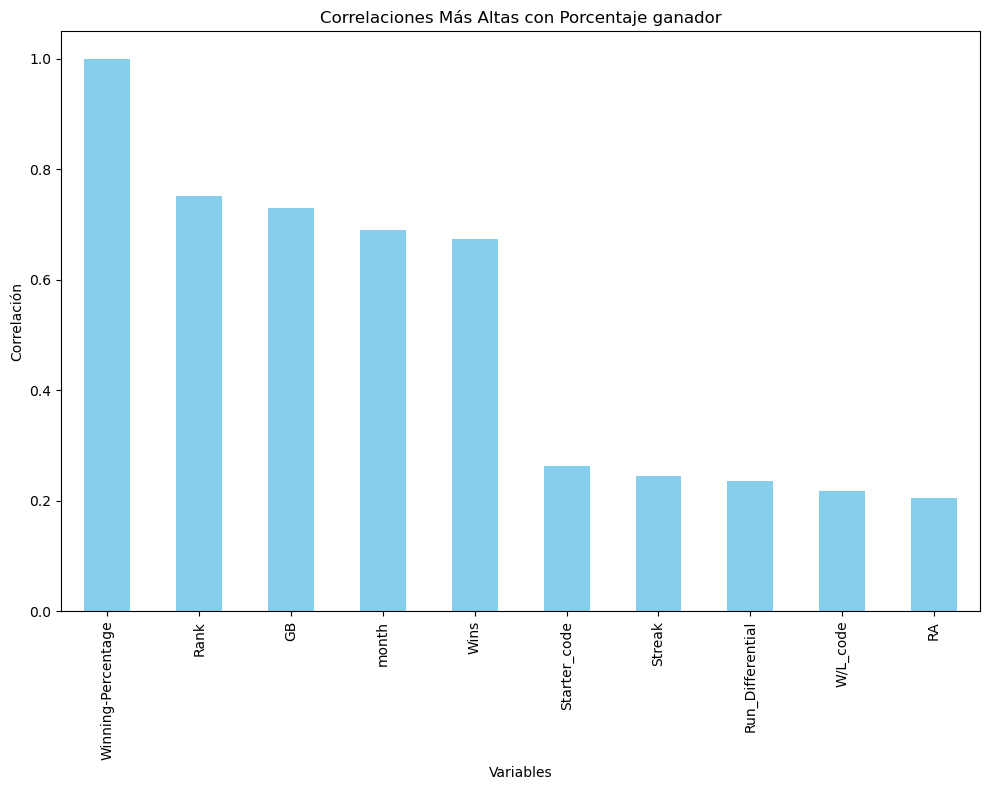

In [38]:
corr_matrix = games[['R', 'RA', 'Inn', 'Run_Differential', 'Streak', 'Rank', 'Home_Away_code', 
                     'Opp_code', 'Win_code', 'Loss_code', 'D/N_code', 'Starter_code', 
                     'GB', 'hour', 'month', 'Winning-Percentage', 'W/L_code', 'Wins']].corr()

# Filtrar las correlaciones más altas (valores absolutos)
highest_corr = corr_matrix.abs().nlargest(10, 'Winning-Percentage')['Winning-Percentage']

# Crear figura y ejes
plt.figure(figsize=(10, 8))

# Graficar barras de las correlaciones más altas
highest_corr.plot(kind='bar', color='skyblue')

# Agregar etiquetas y título
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.title('Correlaciones Más Altas con Porcentaje ganador')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

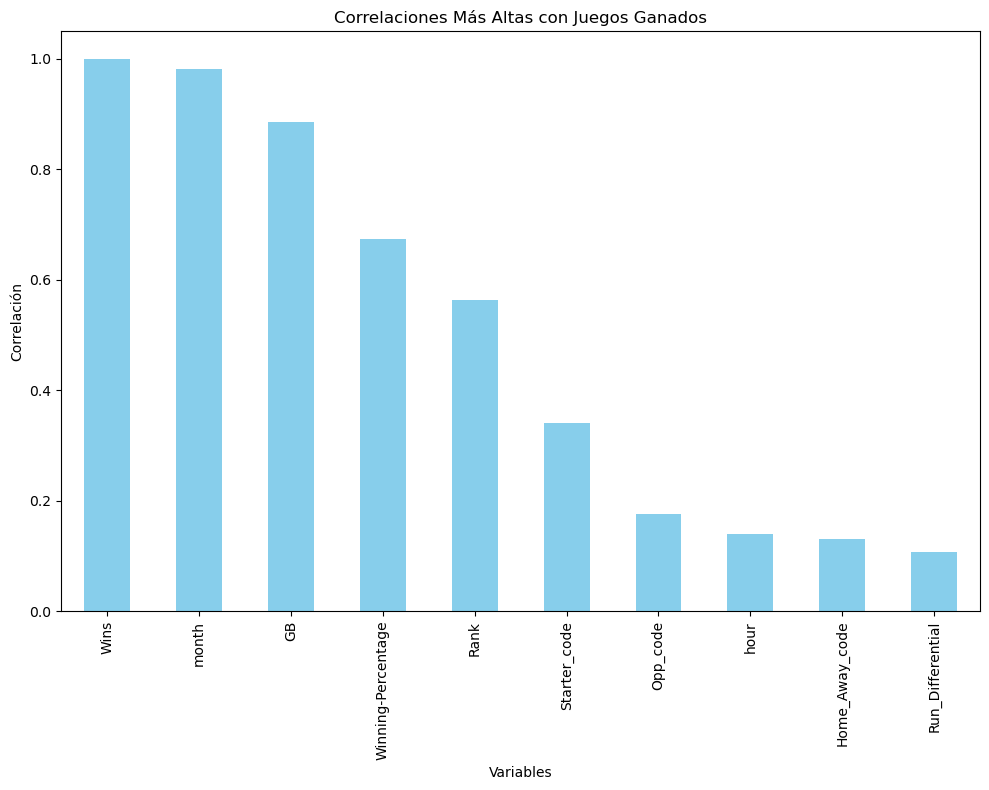

In [39]:
corr_matrix = games[['R', 'RA', 'Inn', 'Run_Differential', 'Streak', 'Rank', 'Home_Away_code', 
                     'Opp_code', 'Win_code', 'Loss_code', 'D/N_code', 'Starter_code', 
                     'GB', 'hour', 'month', 'Winning-Percentage', 'W/L_code', 'Wins']].corr()

highest_corr = corr_matrix.abs().nlargest(10, 'Wins')['Wins']

plt.figure(figsize=(10, 8))

highest_corr.plot(kind='bar', color='skyblue')

plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.title('Correlaciones Más Altas con Juegos Ganados')

plt.tight_layout()
plt.show()

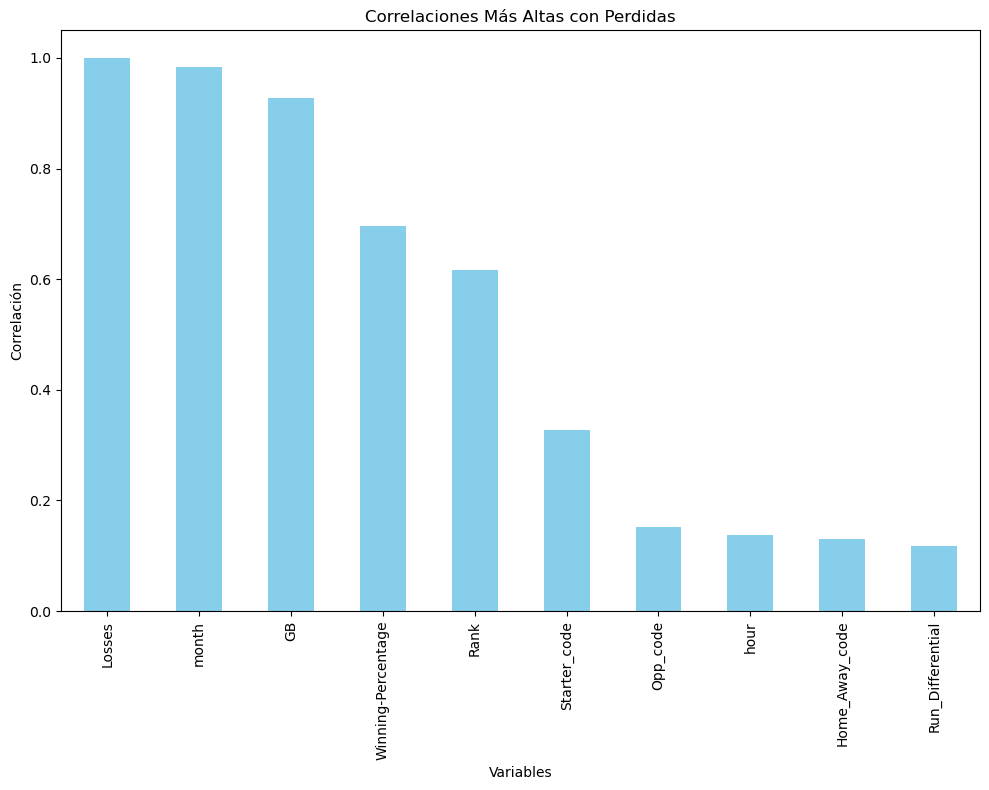

In [40]:
corr_matrix = games[['R', 'RA', 'Inn', 'Run_Differential', 'Streak', 'Rank', 'Home_Away_code', 
                     'Opp_code', 'Win_code', 'Loss_code', 'D/N_code', 'Starter_code', 
                     'GB', 'hour', 'month', 'Winning-Percentage', 'W/L_code', 'Losses']].corr()

highest_corr = corr_matrix.abs().nlargest(10, 'Losses')['Losses']

# Crear figura y ejes
plt.figure(figsize=(10, 8))

# Graficar barras de las correlaciones más altas
highest_corr.plot(kind='bar', color='skyblue')

# Agregar etiquetas y título
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.title('Correlaciones Más Altas con Perdidas')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

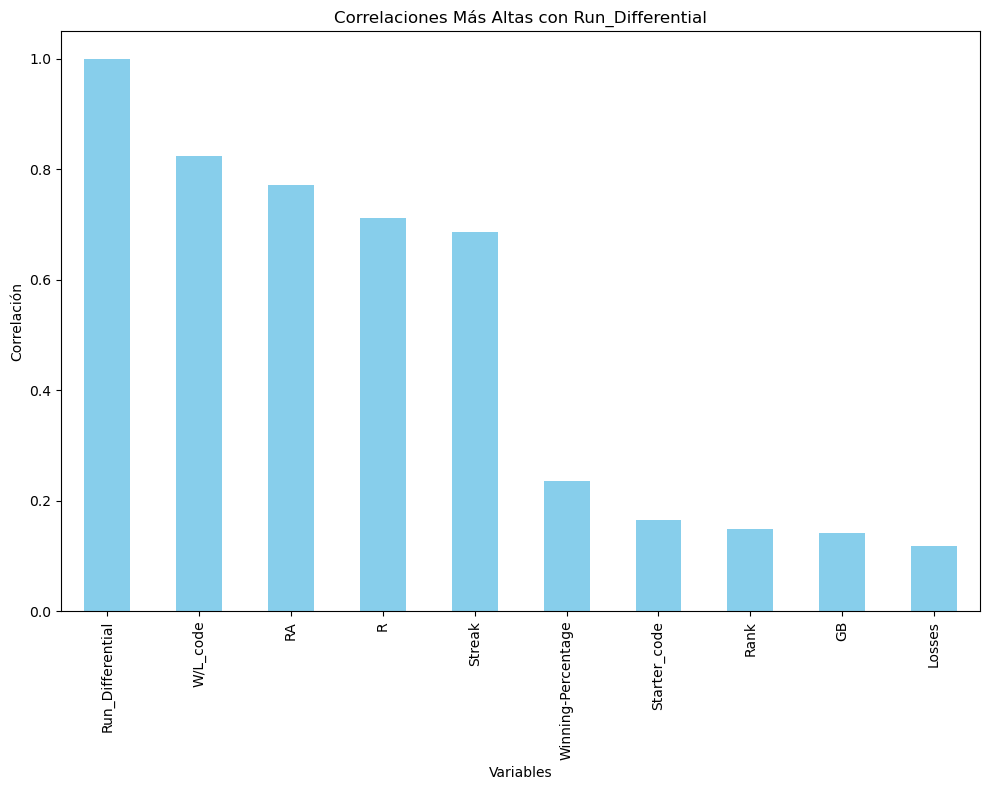

In [41]:
corr_matrix = games[['R', 'RA', 'Inn', 'Run_Differential', 'Streak', 'Rank', 'Home_Away_code', 
                     'Opp_code', 'Win_code', 'Loss_code', 'D/N_code', 'Starter_code', 
                     'GB', 'hour', 'month', 'Winning-Percentage', 'W/L_code', 'Losses']].corr()

highest_corr = corr_matrix.abs().nlargest(10, 'Run_Differential')['Run_Differential']

# Crear figura y ejes
plt.figure(figsize=(10, 8))

# Graficar barras de las correlaciones más altas
highest_corr.plot(kind='bar', color='skyblue')

# Agregar etiquetas y título
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.title('Correlaciones Más Altas con Run_Differential')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Variable objetivo
- Si el equipo gana (Booleano)


## Definiendo mis features
- Rank 
- Month 
- Gb
- Streak
- Starter code
- W/L_code
- Opponente (No lo termine usando porque para usarlo tenia que hacer 2 groupby y en este caso opte por groupby starter)
- Run differential  



In [42]:
#Calculando el rolling sum o el cumulativo de run differetial dsps de cada juego    
games['Run_Differential'] = games['R'] - games['RA']

games['Cumulative_Run_Differential'] = games['Run_Differential'].cumsum()

In [43]:
games.drop(columns=['Inn', 'cLI', 'D/N', 'hour', 'day', 'D/N_code'], inplace=True)
games.head()


,Date,Tm,Home_Away,Opp,W/L,R,RA,Rank,GB,Win,...,Run_Differential,Winning-Percentage,Home_Away_code,Opp_code,Win_code,Loss_code,Starter_code,month,W/L_code,Cumulative_Run_Differential
1,2023-03-30,NYY,Home,SFG,W,5.0,0.0,1.0,0.0,Cole,...,5.0,1.000000,1,23,18,87,1,3,1,5.0
2,2023-04-01,NYY,Home,SFG,L,5.0,7.0,2.0,1.0,Junis,...,-2.0,0.500000,1,23,46,39,8,4,0,3.0
3,2023-04-02,NYY,Home,SFG,W,6.0,0.0,2.0,1.0,Brito,...,6.0,0.666667,1,23,14,79,0,4,1,9.0
4,2023-04-03,NYY,Home,PHI,W,8.0,1.0,2.0,1.0,Cortés,...,7.0,0.750000,1,19,21,85,3,4,1,16.0
5,2023-04-04,NYY,Home,PHI,L,1.0,4.0,2.0,2.0,Bellatti,...,-3.0,0.600000,1,19,7,17,4,4,0,13.0


In [44]:
games.head()


,Date,Tm,Home_Away,Opp,W/L,R,RA,Rank,GB,Win,...,Run_Differential,Winning-Percentage,Home_Away_code,Opp_code,Win_code,Loss_code,Starter_code,month,W/L_code,Cumulative_Run_Differential
1,2023-03-30,NYY,Home,SFG,W,5.0,0.0,1.0,0.0,Cole,...,5.0,1.000000,1,23,18,87,1,3,1,5.0
2,2023-04-01,NYY,Home,SFG,L,5.0,7.0,2.0,1.0,Junis,...,-2.0,0.500000,1,23,46,39,8,4,0,3.0
3,2023-04-02,NYY,Home,SFG,W,6.0,0.0,2.0,1.0,Brito,...,6.0,0.666667,1,23,14,79,0,4,1,9.0
4,2023-04-03,NYY,Home,PHI,W,8.0,1.0,2.0,1.0,Cortés,...,7.0,0.750000,1,19,21,85,3,4,1,16.0
5,2023-04-04,NYY,Home,PHI,L,1.0,4.0,2.0,2.0,Bellatti,...,-3.0,0.600000,1,19,7,17,4,4,0,13.0


In [45]:
games.drop(columns=['Save'], inplace=True)
games.drop(columns=['Time'], inplace=True)



In [46]:
games.columns

Index(['Date', 'Tm', 'Home_Away', 'Opp', 'W/L', 'R', 'RA', 'Rank', 'GB', 'Win',
       'Loss', 'Streak', 'Starter', 'Wins', 'Losses', 'Run_Differential',
       'Winning-Percentage', 'Home_Away_code', 'Opp_code', 'Win_code',
       'Loss_code', 'Starter_code', 'month', 'W/L_code',
       'Cumulative_Run_Differential'],
      dtype='object')

In [47]:


def plot_holt_model(result, x, y):
    result['Date'] = pd.to_datetime(result['Date'])
    
    model = ExponentialSmoothing(y, trend='additive', seasonal=None)
    model_fit = model.fit()
    
    y_pred = model_fit.predict(start=0, end=len(y)-1)

    r_squared = r2_score(y, y_pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(result['Date'], y, marker='o', linestyle='-', color='b', label='Wins')
    plt.plot(result['Date'], y_pred, color='green', linestyle='-', label=f'Holt Predictions (R² = {r_squared:.2f})')
    plt.title('Victorias a lo largo del tiempo usando Holt Model')
    plt.xlabel('Date')
    plt.ylabel('Wins')
    plt.legend()
    plt.grid(True)
    plt.annotate(f"R² = {r_squared:.3f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, 
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    plt.show()

def plot_gbm_model(result, X, y):
    result['Date'] = pd.to_datetime(result['Date'])
    
    gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gbm_model.fit(X, y)
    y_pred = gbm_model.predict(X)
    
    r_squared = r2_score(y, y_pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(result['Date'], y, marker='o', linestyle='-', color='b', label='Winning Percentage')
    plt.plot(result['Date'], y_pred, color='green', linestyle='-', label=f'GBM Predictions (R² = {r_squared:.2f})')
    plt.title('Porcentaje de Victorias a lo largo del tiempo usando Gradient Boosting Machines')
    plt.xlabel('Date')
    plt.ylabel('Winning Percentage')
    plt.legend()
    plt.grid(True)
    plt.annotate(f"R² = {r_squared:.3f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, 
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    plt.show()

def plot_rf_model(result, X, y):
    result['Date'] = pd.to_datetime(result['Date'])
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=52)
    rf_model.fit(X, y)
    y_rf_predicted = rf_model.predict(X)
    
    r_squared_rf = r2_score(y, y_rf_predicted)
    
    plt.figure(figsize=(10, 6))
    plt.plot(result['Date'], y, marker='o', linestyle='-', color='b', label='Winning Percentage')
    plt.plot(result['Date'], y_rf_predicted, color='green', linestyle='-', 
             label=f'Random Forest Predictions (R² = {r_squared_rf:.2f})')
    plt.title('Porcentaje de Victorias a lo largo del tiempo usando Random Forest')
    plt.xlabel('Date')
    plt.ylabel('Winning Percentage')
    plt.legend()
    plt.grid(True)
    plt.annotate(f"R² = {r_squared_rf:.3f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, 
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    plt.show()



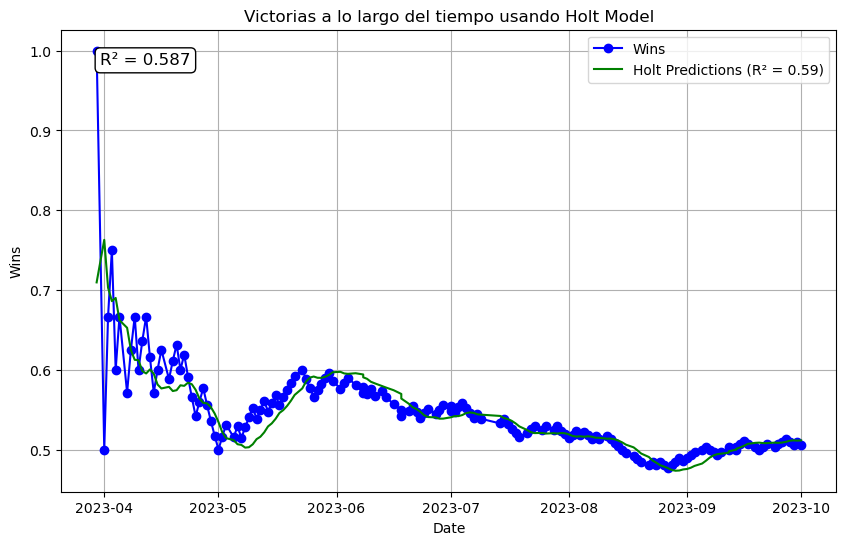

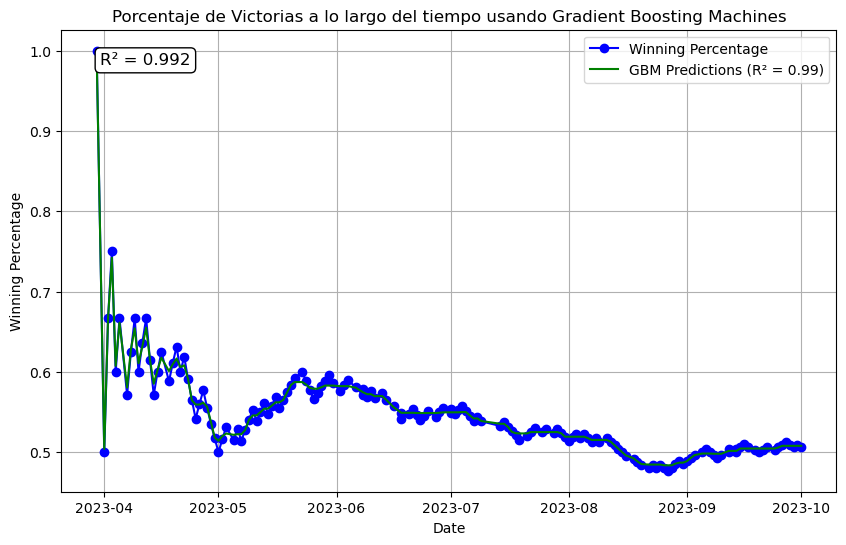

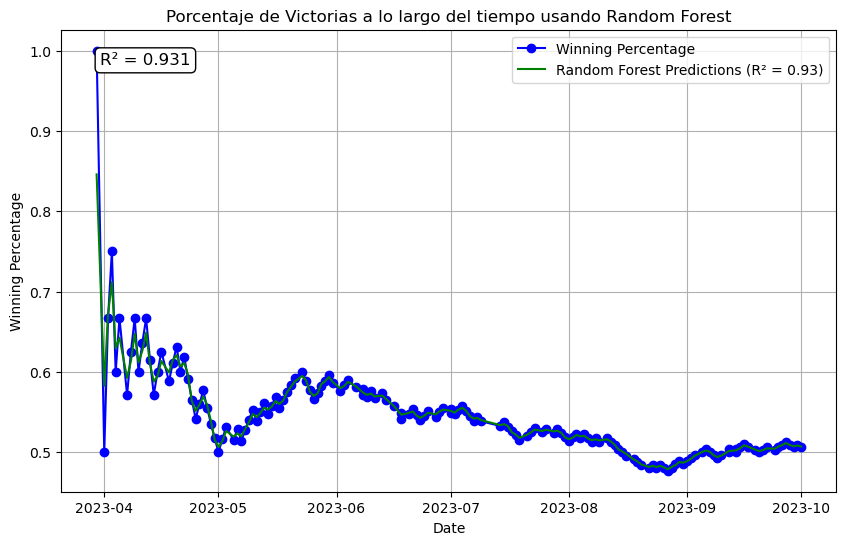

In [48]:
plot_holt_model(games, games[['Date']], games['Winning-Percentage'])
plot_gbm_model(games, games[['Date']], games['Winning-Percentage'] )
plot_rf_model(games, games[['Date']], games['Winning-Percentage'])



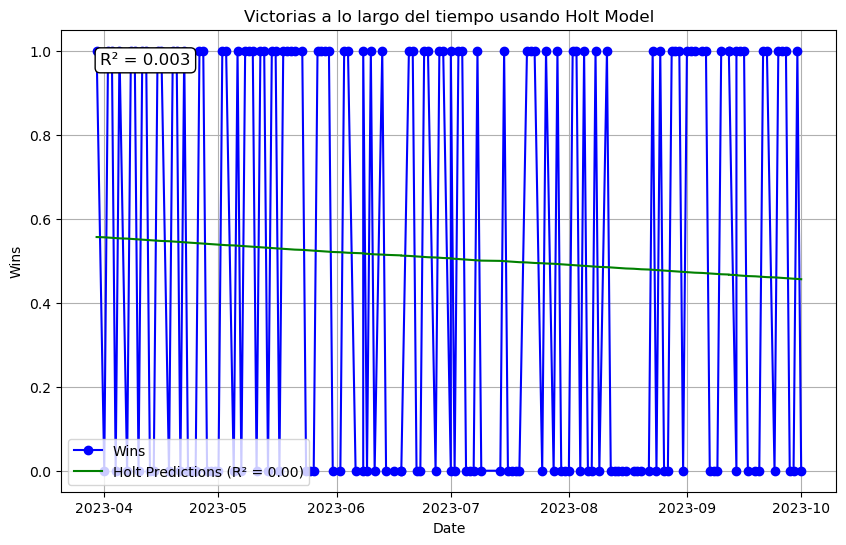

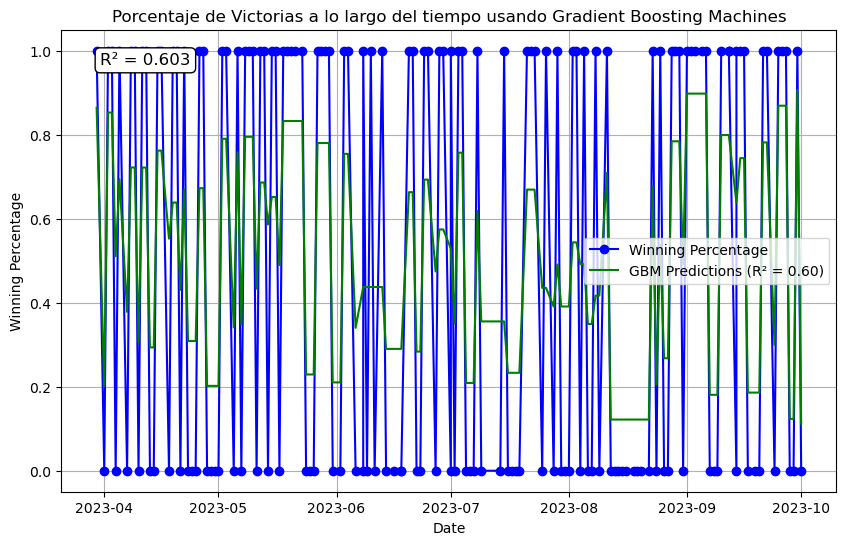

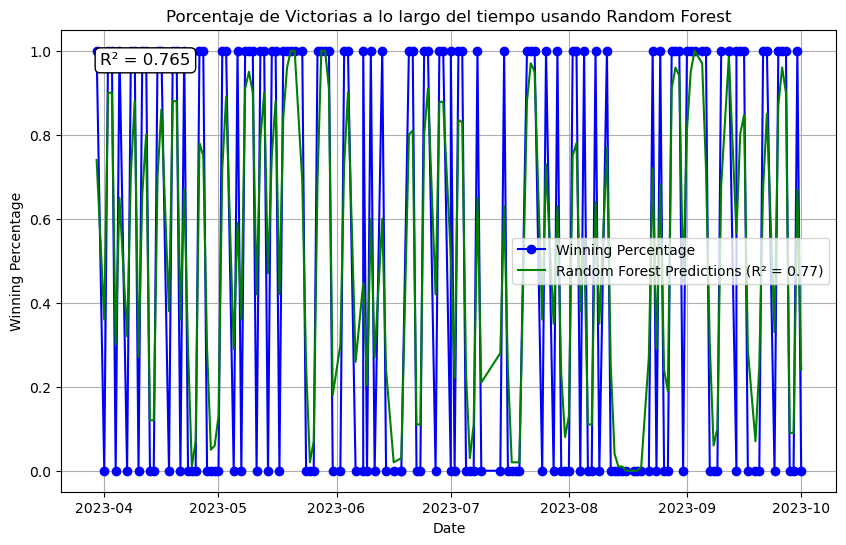

In [49]:
plot_holt_model(games, games[['Date']], games['W/L_code'])
plot_gbm_model(games, games[['Date']], games['W/L_code'] )
plot_rf_model(games, games[['Date']], games['W/L_code'])



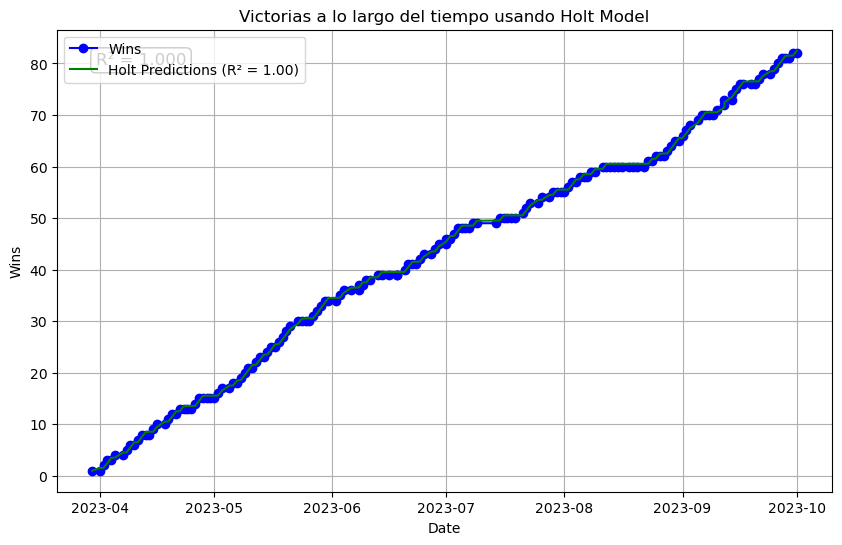

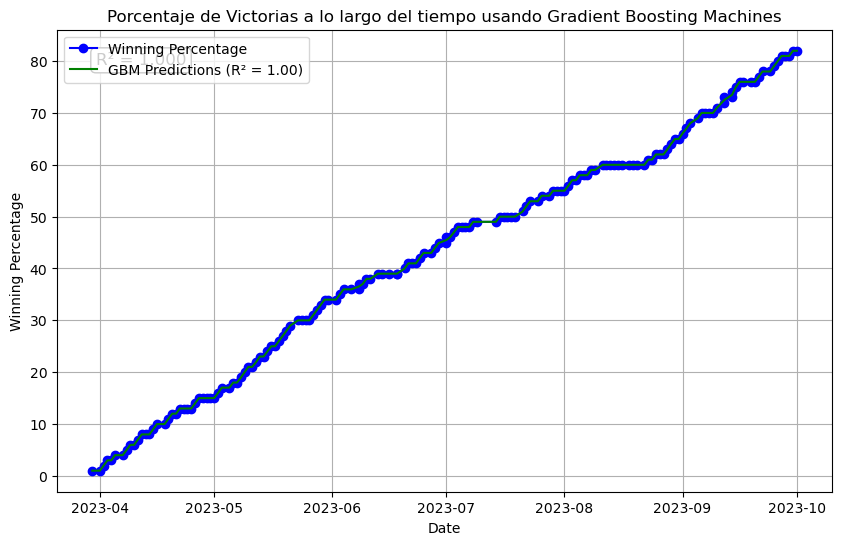

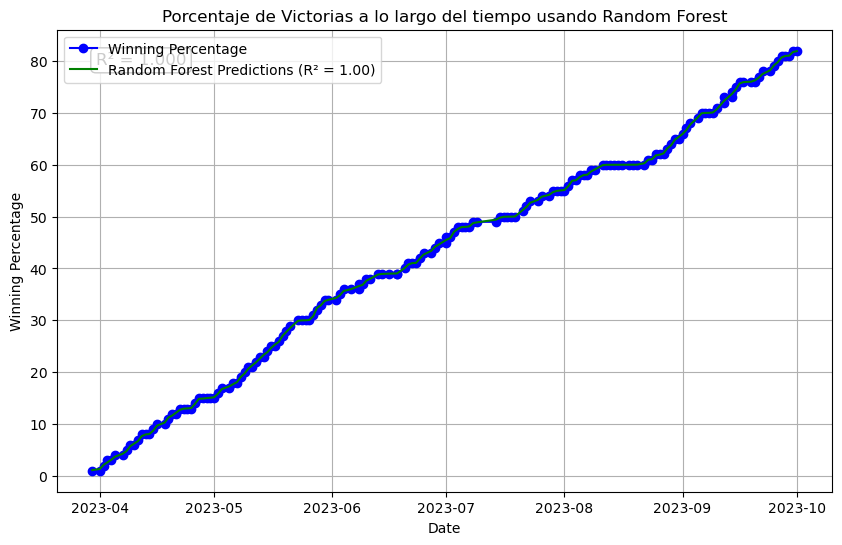

In [50]:
plot_holt_model(games, games[['Date']], games['Wins'])
plot_gbm_model(games, games[['Date']], games['Wins'] )
plot_rf_model(games, games[['Date']], games['Wins'])

In [51]:
games['target'] = (games['W/L'] == 'W').astype('int')
games['Opp_code'] = games['Opp'].astype('category').cat.codes


In [52]:
games.columns

Index(['Date', 'Tm', 'Home_Away', 'Opp', 'W/L', 'R', 'RA', 'Rank', 'GB', 'Win',
       'Loss', 'Streak', 'Starter', 'Wins', 'Losses', 'Run_Differential',
       'Winning-Percentage', 'Home_Away_code', 'Opp_code', 'Win_code',
       'Loss_code', 'Starter_code', 'month', 'W/L_code',
       'Cumulative_Run_Differential', 'target'],
      dtype='object')

In [53]:
rf= RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

In [54]:
train = games[games['Date'] < '2023-05-30']
test = games[games['Date'] > '2023-05-30']

In [55]:
#Run differential, Rank Month Gb Streak Starter code, W/L_code, Opponente
predictors = [ 'Rank', 'GB', 'Starter_code', 'month', 'Cumulative_Run_Differential']

In [56]:
predictors

['Rank', 'GB', 'Starter_code', 'month', 'Cumulative_Run_Differential']

In [57]:
rf.fit(train[predictors], train['target'])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

In [58]:
predictions = rf.predict(test[predictors])

In [59]:
acc = accuracy_score(test['target'], predictions)

In [60]:
acc

0.5142857142857142

In [61]:
combined = pd.DataFrame(dict(actual=test['target'], prediction = predictions))

In [62]:
pd.crosstab(index=combined['actual'], columns = combined['prediction'])

prediction,0,1
actual,,
0,32,25
1,26,22


In [63]:
precision_score(test['target'], predictions)

0.46808510638297873

In [64]:
combined

,actual,prediction
58,0,1
59,0,1
60,1,1
61,1,1
62,0,1
...,...,...
158,1,0
159,0,0
160,0,0
161,1,0


In [65]:
grouped_games = games.groupby("Starter")
group = grouped_games.get_group("Cole").sort_values("Date")

In [66]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [67]:
games.columns

Index(['Date', 'Tm', 'Home_Away', 'Opp', 'W/L', 'R', 'RA', 'Rank', 'GB', 'Win',
       'Loss', 'Streak', 'Starter', 'Wins', 'Losses', 'Run_Differential',
       'Winning-Percentage', 'Home_Away_code', 'Opp_code', 'Win_code',
       'Loss_code', 'Starter_code', 'month', 'W/L_code',
       'Cumulative_Run_Differential', 'target'],
      dtype='object')

In [95]:
cols = ['Rank', 'GB',
       'Streak', 'Wins', 'Losses', 'Run_Differential',
       'Winning-Percentage', 'Cumulative_Run_Differential']
new_cols = [f"{c}_rolling" for c in cols]

rolling_averages(group, cols, new_cols)

,Date,Tm,Home_Away,Opp,W/L,R,RA,Rank,GB,Win,...,Cumulative_Run_Differential,target,Rank_rolling,GB_rolling,Streak_rolling,Wins_rolling,Losses_rolling,Run_Differential_rolling,Winning-Percentage_rolling,Cumulative_Run_Differential_rolling
16,2023-04-16,NYY,Home,MIN,W,2.0,0.0,2.0,4.0,Cole,...,25.0,1,1.666667,2.000000,1.000000,4.000000,2.000000,5.333333,0.767677,15.666667
21,2023-04-22,NYY,Home,TOR,W,3.0,2.0,3.0,5.0,Cordero,...,25.0,1,2.000000,3.333333,1.333333,7.000000,4.000000,4.333333,0.642677,22.333333
26,2023-04-27,NYY,@,TEX,W,4.0,2.0,4.0,6.0,Cole,...,20.0,1,2.333333,4.333333,1.333333,10.000000,6.000000,4.000000,0.626804,25.666667
31,2023-05-02,NYY,Home,CLE,W,4.0,2.0,5.0,8.5,Peralta,...,3.0,1,3.000000,5.000000,1.666667,12.666667,8.333333,1.666667,0.606990,23.333333
35,2023-05-07,NYY,@,TBR,L,7.0,8.0,5.0,10.0,Beeks,...,3.0,0,4.000000,6.500000,1.333333,14.666667,11.333333,1.666667,0.570700,16.000000
40,2023-05-12,NYY,Home,TBR,W,6.0,5.0,5.0,8.0,Holmes,...,16.0,1,4.666667,8.166667,0.666667,16.333333,14.333333,1.000000,0.535779,8.666667
45,2023-05-17,NYY,@,TOR,L,0.0,3.0,4.0,7.5,Romano,...,19.0,0,5.000000,8.833333,0.333333,18.666667,16.666667,0.666667,0.526805,7.333333
50,2023-05-23,NYY,Home,BAL,W,6.0,5.0,3.0,5.0,King,...,32.0,1,4.666667,8.500000,-0.333333,21.666667,18.333333,-1.000000,0.539947,12.666667
55,2023-05-28,NYY,Home,SDP,W,10.0,7.0,3.0,7.0,Cole,...,27.0,1,4.000000,6.833333,1.666667,25.666667,19.333333,-0.333333,0.568519,22.333333
60,2023-06-03,NYY,@,LAD,W,6.0,3.0,3.0,6.0,Cole,...,39.0,1,3.333333,6.500000,2.000000,29.000000,21.000000,0.333333,0.579125,26.000000


In [94]:
games_rolling = games.groupby("Starter").apply(lambda x: rolling_averages(x, cols, new_cols))


In [84]:
games_rolling

Date   Tm Home_Away  Opp W/L     R   RA  Rank    GB  \
Starter                                                                  
Brito    18  2023-04-19  NYY      Home  LAA   W   3.0  2.0   2.0   4.5   
         23  2023-04-24  NYY         @  MIN   L   1.0  6.0   4.0   7.0   
         28  2023-04-29  NYY         @  TEX   L   0.0  2.0   4.0   8.0   
         33  2023-05-05  NYY         @  TBR   L   4.0  5.0   5.0  10.0   
         38  2023-05-10  NYY      Home  OAK   W  11.0  3.0   5.0   8.0   
...                 ...  ...       ...  ...  ..   ...  ...   ...   ...   
Severino 131 2023-08-28  NYY         @  DET   W   4.0  1.0   5.0  19.0   
         136 2023-09-02  NYY         @  HOU   W   5.0  4.0   5.0  17.5   
         141 2023-09-08  NYY      Home  MIL   L   2.0  8.0   5.0  19.5   
Vásquez  121 2023-08-16  NYY         @  ATL   L   0.0  2.0   5.0  14.0   
         144 2023-09-12  NYY         @  BOS   W   3.0  2.0   4.0  18.5   

                   Win  ... Starter_code  month W/L_code  \
Starter                 ...                                
Brito    18   Hamilton  ...            0      4        1   
         23       Gray  ...            0      4        0   
         28    Eovaldi  ...            0      4        0   
         33      Kelly  ...            0      5        0   
         38    Cordero  ...            0      5        1   
...                ...  ...          ...    ...      ...   
Severino 131  Severino  ...            9      8        1   
         136     Brito  ...            9      9        1   
         141     Uribe  ...            9      9        0   
Vásquez  121    Morton  ...           10      8        0   
         144     Brito  ...           10      9        1   

              Cumulative_Run_Differential  target  Rank_rolling  GB_rolling  \
Starter                                                                       
Brito    18                          23.0       1      2.000000    3.000000   
         23                          16.0       0      2.000000    4.166667   
         28                          15.0       0      2.666667    5.500000   
         33                           3.0       0      3.333333    6.500000   
         38                          21.0       1      4.333333    8.333333   
...                                   ...     ...           ...         ...   
Severino 131                        -20.0       1      5.000000   14.000000   
         136                        -10.0       1      5.000000   16.666667   
         141                        -13.0       0      5.000000   17.833333   
Vásquez  121                        -14.0       0      3.000000    8.166667   
         144                        -18.0       1      3.666667   10.166667   

              Streak_rolling  Winning-Percentage_rolling  \
Starter                                                    
Brito    18         0.333333                    0.635684   
         23         0.333333                    0.617165   
         28        -0.666667                    0.597238   
         33        -1.000000                    0.570681   
         38        -1.666667                    0.538694   
...                      ...                         ...   
Severino 131       -1.333333                    0.500770   
         136       -0.666667                    0.488348   
         141        1.333333                    0.485897   
Vásquez  121       -1.000000                    0.565296   
         144       -1.666667                    0.541906   

              Cumulative_Run_Differential_rolling  
Starter                                            
Brito    18                             15.000000  
         23                             19.666667  
         28                             19.333333  
         33                             18.000000  
         38                             11.333333  
...                                           ...  
Severino 131                            -9.333333 

In [85]:
games_rolling = games_rolling.droplevel('Starter')


In [86]:
games_rolling

,Date,Tm,Home_Away,Opp,W/L,R,RA,Rank,GB,Win,...,Starter_code,month,W/L_code,Cumulative_Run_Differential,target,Rank_rolling,GB_rolling,Streak_rolling,Winning-Percentage_rolling,Cumulative_Run_Differential_rolling
18,2023-04-19,NYY,Home,LAA,W,3.0,2.0,2.0,4.5,Hamilton,...,0,4,1,23.0,1,2.000000,3.000000,0.333333,0.635684,15.000000
23,2023-04-24,NYY,@,MIN,L,1.0,6.0,4.0,7.0,Gray,...,0,4,0,16.0,0,2.000000,4.166667,0.333333,0.617165,19.666667
28,2023-04-29,NYY,@,TEX,L,0.0,2.0,4.0,8.0,Eovaldi,...,0,4,0,15.0,0,2.666667,5.500000,-0.666667,0.597238,19.333333
33,2023-05-05,NYY,@,TBR,L,4.0,5.0,5.0,10.0,Kelly,...,0,5,0,3.0,0,3.333333,6.500000,-1.000000,0.570681,18.000000
38,2023-05-10,NYY,Home,OAK,W,11.0,3.0,5.0,8.0,Cordero,...,0,5,1,21.0,1,4.333333,8.333333,-1.666667,0.538694,11.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,2023-08-28,NYY,@,DET,W,4.0,1.0,5.0,19.0,Severino,...,9,8,1,-20.0,1,5.000000,14.000000,-1.333333,0.500770,-9.333333
136,2023-09-02,NYY,@,HOU,W,5.0,4.0,5.0,17.5,Brito,...,9,9,1,-10.0,1,5.000000,16.666667,-0.666667,0.488348,-17.333333
141,2023-09-08,NYY,Home,MIL,L,2.0,8.0,5.0,19.5,Uribe,...,9,9,0,-13.0,0,5.000000,17.833333,1.333333,0.485897,-16.666667
121,2023-08-16,NYY,@,ATL,L,0.0,2.0,5.0,14.0,Morton,...,10,8,0,-14.0,0,3.000000,8.166667,-1.000000,0.565296,34.000000


In [87]:
games_rolling.index = range(games_rolling.shape[0])


In [88]:
def make_predictions(data, predictors):
    train = data[data["Date"] < '2023-05-30']
    test = data[data["Date"] > '2023-05-30']
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    error = precision_score(test["target"], preds)
    return combined, error

In [89]:
combined, error = make_predictions(games_rolling, predictors + new_cols)


In [90]:
error


0.48717948717948717

In [91]:
combined = combined.merge(games_rolling[["Date", "Opp", "W/L"]], left_index=True, right_index=True)
combined

,actual,predicted,Date,Opp,W/L
6,1,1,2023-06-21,SEA,W
7,0,1,2023-06-27,OAK,L
8,0,1,2023-07-31,TBR,L
9,0,0,2023-08-18,BOS,L
19,1,1,2023-06-03,LAD,W
...,...,...,...,...,...
123,1,1,2023-08-28,DET,W
124,1,1,2023-09-02,HOU,W
125,0,1,2023-09-08,MIL,L
126,0,0,2023-08-16,ATL,L


In [92]:
predicted_res=combined["predicted"].replace({0: 'loss', 1: 'win'}).value_counts()
predicted_res

win     78
loss    12
Name: predicted, dtype: int64

In [93]:

actual_res=combined["actual"].replace({0: 'loss', 1: 'win'}).value_counts()
actual_res


loss    48
win     42
Name: actual, dtype: int64

In [80]:

const = 1e-10  
mape = np.mean(np.abs((test["target"] - predictions) / (test["target"] + const))) * 100
mad = mean_absolute_error(test["target"], predictions)
sd = np.std(test["target"] - predictions)
tst_rango_ts_inf = np.percentile(predictions - test["target"], 2.5)
tst_rango_ts_sup = np.percentile(predictions - test["target"], 97.5)



In [81]:
print( 'mape: ', mape)
print('MAD: ', mad)
print('SD: ', sd)
print('tst rango ts inferior: ', tst_rango_ts_inf)
print('tst rango ts superior: ', tst_rango_ts_sup)


mape:  238095238119.99997
MAD:  0.4857142857142857
SD:  0.6968669763781599
tst rango ts inferior:  -1.0
tst rango ts superior:  1.0
